# Project Description

## Purpose
Estimate the parameters ρ, σₐ², σᵤ² of Larry Karp's emissions
    model using iterated Feasible GLS and MLE

How: Most of this script defines functions that represent equations from
    the model. In later sections, the equations are used to iteratively estimate:
    (1) the GLS parameters b₀ᵢ and β (time trend) as inputs to (2)
    (2) the MLE parameters ρ, σₐ², σᵤ²

First, I test this on generated data that we know the parameter values
    for to see how close the estimates are to the "true" values. I test
    the estimates using different values of T, N, σₐ², σᵤ². (This is done
    in `julia/covariance_matrix.jl`, but not currently in this notebook)

Lastly, I estimate the paramters on the actual data that
    Larry provided, using different starting values for the parameters. 
    These starting values are used in the minimization function in the
    MLE function.

Time to run: Most of the functions at the end that actually run the
    estimations also have time estimates in a comment after them. These
    were run on a linux computer with 32 GB of RAM and 
    AMD Ryzen 3 2300x quad-core processor. Times may be more or less
    depending on your system. Julia does multithreading automatically,
    meaning it will take up all available CPU during most compuations
    until the script has complete. If you do not want Julia to use all your CPU cores,
    I think you can use the [following code](https://discourse.julialang.org/t/enable-multiple-cores-for-jupyter-lab/18658/7) to set a fewer number of cores to be used:
    
```
using IJulia
installkernel("Julia (n threads)", env=Dict("JULIA_NUM_THREADS"=>"n"))
```
where you can replace `n` with the number of cores you wish to use.

# Packages
Loading packages can often take a long time, but Julia is very fast once packages are loaded

In [1]:

# import Pkg; Pkg.add("TableView")
# Pkg.add("WebIO")
# Pkg.add("CategoricalArrays")
# Pkg.add("Optim")
# Pkg.add("Latexify")
using Random              # Random numbers
using Distributions       # Probability distributions
using DataFrames          # R-style dataframes
using DataFramesMeta      # Additional dataframe functions (like R chaining)
using TableView           # Display nice tables in REPL and notebook (showtable func)
using WebIO               # Required for TableView
using CategoricalArrays   # Categorical variables in dataframes (helpful when running regressions with factor vars)
using LinearAlgebra       # Diagonal matrix, getting the diagonal of a matrix
using StatsModels         # formulas and modelmatrix
using GLM                 # OLS (lm) and GLS (glm)
using Optim               # optimize (minimizing)
# using Symbolics           # symbolic functions
import Dates              
using Latexify            # output symbolic expressions as latex code
# using ModelingToolkit  # more symbolic matrix functions
# using Reduce  # more symbolic matrix functions (specifically Reduce.Algebra.^)
# @force using Reduce.Algebra  # to extend native functions to Sybmol/Expr types
using Logging            # Saving verbose output to logs to help with debugging later
import CSV               # save to and read from CSVs

# Setup
Setup the logger

In [9]:
io = open("log.txt", "a")
logger = SimpleLogger(io)
# debuglogger = ConsoleLogger(stderr, Logging.Debug)
global_logger(logger)
s = "\n"^20 * "="^60 * "\nCOVARIANCE MATRIX ESTIMATION BEGIN\n" * "="^60
@info s Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")

# Equation Functions
These are the functions defined in Larry Karp's Ranking Policies working paper. 


## Covariance Matrix Equations

In [11]:
# Indicator functions
ι(i, j) = (i == j ? 1 : 0)
κ(s) = (s == 0 ? 0 : 1)
χ(ρ, i, j, s, N) = (1 - κ(s)) * ι(i, j) + κ(s) * ρ^s / N + ρ^(2 + s) / (N * (1 - ρ))


# Element of the covariance matrix: Σ = E[vᵢₜvⱼₜ₊ₛ]
Evᵢₜvⱼₜ₊ₛ(ρ, σₐ², σᵤ², i, j, s, N; b = 1) = 1 / b^2 * (σₐ² * ρ^s / (1 - ρ^2) + χ(ρ, i, j, s, N) * σᵤ²)

# i,t, j,t+s Elements of ∂Σ/∂y for y ∈ {ρ, σₐ², σᵤ²}
∂Σ∂ρ(ρ, σₐ², σᵤ², i, j, s, N) = ρ^(s-1) / N / (ρ^2 - 1)^2 * (
    (s*κ(s) + (2 + s - 2*s*κ(s))*ρ^2 + (s*κ(s) - s)*ρ^4)*σᵤ² +
    (N*(2-s)*ρ^2 + N*s)*σₐ²
)

∂Σ∂σₐ²(ρ, σₐ², σᵤ², i, j, s, N) = ρ^s / (1 - ρ^2)

∂Σ∂σᵤ²(ρ, σₐ², σᵤ², i, j, s, N) = χ(ρ, i, j, s, N)

derivatives = Dict("ρ" => ∂Σ∂ρ, "σₐ²" => ∂Σ∂σₐ², "σᵤ²" => ∂Σ∂σᵤ²)

# General derivative ∂Σ/∂y for y ∈ {"ρ", "σₐ²", "σᵤ²"} (quotes needed for y input)
∂Σ∂y(y, ρ, σₐ², σᵤ², i, j, s, N) = derivatives[y](ρ, σₐ², σᵤ², i, j, s, N)




"""
    Σ(ρ, σₐ², σᵤ², N, T)

Return the residuals' analytical N*TxN*T covariance matrix given values of parameters
@param ρ: float in [0,1], decay rate of AR1 emissions process
@param σₐ²: float >0, SD of year-specific emissions shock 
@param σᵤ²: float >0, SD of region-year-specific emissions shock
@param N: int>1, number of units/regions
@param T: int>1, number of time periods
"""
function Σ(ρ, σₐ², σᵤ², N, T; verbose = false)
    # Initalize matrix of 0s
    V = zeros(N * T, N * T)

    # Fill in upper triangle
    idx = [(i, j) for i ∈ 1:N*T for j ∈ i:N*T]
    for (row, col) in idx
        t = Integer(ceil(row / N))
        i = row - (t - 1) * N

        τ = Integer(ceil(col / N))
        s = τ - t
        j = col - (τ - 1) * N

        V[row, col] = Evᵢₜvⱼₜ₊ₛ(ρ, σₐ², σᵤ², i, j, s, N)
        a = [i, t, j, τ, row, col]
    end

    # Fill in lower triangle by symmetry
    V = Symmetric(V)
    if verbose
        println("\nFull Covariance Matirx:")
        for r in 1:size(V)[1]
            println(round.(V[r, :]; sigdigits = 4))
        end
    end
    return (V)
end


"""
Function to fill the NT x NT matrix with elements defined by ijs_func
"""
function fill_matrix(ijs_func, ρ, σₐ², σᵤ², N, T; verbose = false)
    # Initalize matrix of 0s
    mat = zeros(N * T, N * T)

    # Fill in upper triangle
    idx = [(i, j) for i ∈ 1:N*T for j ∈ i:N*T]
    for (row, col) in idx
        t = Integer(ceil(row / N))
        i = row - (t - 1) * N

        τ = Integer(ceil(col / N))
        s = τ - t
        j = col - (τ - 1) * N

        mat[row, col] = ijs_func(ρ, σₐ², σᵤ², i, j, s, N)
    end

    # Fill in lower triangle by symmetry
    mat = Symmetric(mat)
    if verbose
        println("\nFull NT x NT Matirx:")
        for r in 1:size(mat)[1]
            println(round.(mat[r, :]; sigdigits = 4))
        end
    end
    return (mat)
end;



## Negative Log Likelihood equations
We want to maximize the likelihood over values of ρ, σₐ², σᵤ²

=> maximize the log likelihood
    
=> minimize the negative log likelihood (nLL)

To find the minimal parameter vector more efficiently, we can use gradient descent. This requires calculating the derivative of the nLL for any given value of parameters in the support of the likelihood function.

In [12]:
# Negative Log Likelihood (want to minimize)
function nLL(ρ, σₐ², σᵤ², v, N, T)
    V = Σ(ρ,σₐ²,σᵤ²,N,T)
    nLL = (1/2) * ( v'*V^-1*v + log(det(V)) )
    return(nLL)
end

function ∂nLL∂y(y, ρ, σₐ², σᵤ², v, N, T)
    ijs_fun(ρ, σₐ², σᵤ², i, j, s, N) = ∂Σ∂y(y, ρ, σₐ², σᵤ², i, j, s, N)
    ∂V∂y = fill_matrix(ijs_fun, ρ, σₐ², σᵤ², N, T)

    V = Σ(ρ,σₐ²,σᵤ²,N,T)
    vV⁻¹∂V∂yV⁻¹v = v'*V^-1*∂V∂y*V^-1*v
    V⁻¹∂V∂y = V^-1*∂V∂y

    ∂LL∂y = -1/2 * (-vV⁻¹∂V∂yV⁻¹v + tr(V⁻¹∂V∂y))
    return(-∂LL∂y)
end


# Define the gradient of the negative log likelihood
function nLL_grad(gradient_vec, params, v, N, T)
    ρ = params[1]; σₐ² = params[2]; σᵤ² = params[3]
    gradient_vec[1] = ∂nLL∂y("ρ", ρ, σₐ², σᵤ², v, N, T)
    gradient_vec[2] = ∂nLL∂y("σₐ²", ρ, σₐ², σᵤ², v, N, T)
    gradient_vec[3] = ∂nLL∂y("σᵤ²", ρ, σₐ², σᵤ², v, N, T)
end

nLL_grad (generic function with 1 method)

# Estimation procedure
0. Estimate ρ using aggregate global data (in from r-scripts/reproducting_andy.R  -> line 70 result2)
1. Estimate initial region-specific fixed effects b₀ᵢ and time trend β using OLS; save residuals as v
2. Use residuals v in MLE to estimate σₐ², σᵤ²; calculate resulting covariance matrix V
3. Use covariance matrix V in GLS to re-estimate b₀ᵢ and β; save residuals as v
4. Repeat steps 2 and 3 until convergence (until the covariance matrix V stops changing)
5. Report the estimates of b₀ᵢ, β, ρ, σₐ², σᵤ²
6. Repeat steps 1-5 using different starting search values for σₐ² and σᵤ².

**Note**: the MLE results of σₐ², σᵤ² seem to depend on starting search values for σₐ² and σᵤ². Step 6 is to save results over a wide range of starting values to see how the results change.


# Generalized Least Squares
When the identity matrix is used for W, this is simply OLS.

In [13]:
"""
    mygls(formula, df, W, N)

@param formula: StatsModels formula for the linear regression model
@param df: dataframe with columns corresponding to the variables in formula
@param W: nxn weighting matrix, n = length(df)
@param N: number of units
@returns :β, :βse, :yhat, :resid, :βvar, :HC0, :sandwich

# References
- Bruce Hansen Econometrics (2021) section 17.15 Feasible GLS
- Greene Ed 7
- rsusmel lecture notes: bauer.uh.edu/rsusmel/phd/ec1-11.pdf
"""
function mygls(formula, df, W, N)
    println("Starting GLS")
    X = StatsModels.modelmatrix(formula.rhs, df)
    y = StatsModels.modelmatrix(formula.lhs, df)
    XX = inv(X'X)
    XWX = X' * inv(W) * X
    NT, k = size(X)

    β = inv(XWX) * (X' * inv(W) * y)
    yhat = X * β
    resid = y - yhat
    XeX = X' * Diagonal(vec(resid .^ 2)) * X

    # Variance estimators
    # Hansen eq 4.16 (sandwich estimator)
    s = XX * XWX * XX
    s_root = diag(s) .^ 0.5
    # White estimator (rsusmel pg 11)
    HC0 = XX * XeX * XX
    HC0_root = diag(HC0) .^ 0.5
    # Greene (9-13)
    βvar = inv(XWX) / (NT - N - k)
    βse = diag(βvar) .^ 0.5

    # TODO: Add Newey-West HAC SE estimator.
    #   pg. 20 of bauer.uh.edu/rsusmel/phd/ec1-11.pdf

    # Go with βse for now
    return(Dict(:β => β,
        :βse => βse,
        :yhat => yhat,
        :resid => resid,
        :βvar => βvar,
        :HC0 => HC0_root,
        :sandwich => s_root
    ))
end

mygls

## Maximum Likelihood Estimation (MLE)
This is used to estimate σₐ² and σᵤ² (and ρ) given residuals from a first regression of emissions with time trends and region specific fixed effects (rediduals then are detrended and demeaned emissions data). 

In [14]:
"""
    mymle(ρstart, σₐ²start, σᵤ²start, v)

Return likelihood-maximizing values of ρ, σₐ², and σᵤ².
Given vector of residuals, minimize the 
@param ρstart: float, starting value of ρ
@param σₐ²start: float, starting value of σₐ²
@param σᵤ²start: float, starting value of σᵤ²
@param v: Nx1 vector of residuals
@param N: int>1, number of units/regions
@param T: int>1, number of time periods
@param lower: float 3-vector, lower bounds for parameters ρ, σₐ², σᵤ²
@param upper: float 3-vector, upper bounds for parameters ρ, σₐ², σᵤ²
"""
function mymle_3(ρstart, σₐ²start, σᵤ²start, v, N, T;
    lower = [1e-4, 1e-4, 1e-4], upper = [1 - 1e-4, Inf, Inf], analytical = true)
    println("Starting MLE with $ρstart, $σₐ²start, $σᵤ²start")
    # Starting paramerter values
    params0 = [ρstart, σₐ²start, σᵤ²start]

    # Function of only parameters (given residuals v)
    objective(ρσₐ²σᵤ²) = nLL(ρσₐ²σᵤ²[1], ρσₐ²σᵤ²[2], ρσₐ²σᵤ²[3], v, N, T)

    # Minimize over parameters
    grad!(storage, x) = nLL_grad(storage, x, v, N, T)

    # Calculates gradient with no parameter bounds
    # optimum = optimize(objective, params0, LBFGS())
    # Results in a domain error in the log function because the gradient pushes
    #   it to a negative value inside the log

    # Analytical gradient with no parameter bounds
    # optimum = optimize(objective, grad!, params0, LBFGS())
    # Results in a domain error in the log function because the gradient pushes
    #   it to a negative value inside the log

    if analytical
        # Analytical gradient with parameter bounds
        optimum = optimize(objective, grad!, lower, upper, params0, Fminbox(GradientDescent()))
    else
        # Calculates gradient with parameter bounds
        optimum = optimize(objective, lower, upper, params0, Fminbox(GradientDescent()))
    end

    # Return the values
    LL = -optimum.minimum
    ρ, σₐ², σᵤ² = optimum.minimizer
    return (ρ, σₐ², σᵤ², LL)
end

mymle_3

**NEXT STEP**: if taking the value of ρ as given in the MLE estimation (since we can get a consistent estimate from regressions using aggregated global data), we would like to re-write the MLE function to take ρ as given. Currently, I am just severly restricting the search area of ρ in the MLE to a small neighborhood around our consistent estimate, but it would be more computationally efficient to treat ρ as given. This requires rewriting some of the functions: `mymle_3(), grad!(),` and `nll()` at least. Perhaps most of the functions. It's easy, but will take a little bit more time than just restricting the search area of ρ, so I'm leaving that for a future update.

## Simulating the data generating process
To test the bias and consistency, I have defined a DGP below. This allows estimating parameters from a *known* distribution, so we can compare the estimated paramters with the "true" parameters used to generate the data.

In [15]:
"""
    dgp(ρ, σₐ², σᵤ², β, N, T; v₀, μ₀, σ₀)

Return simulated data from the data generating process given paramters.
@param ρ: float in [0,1], decay rate of AR1 emissions process
@param σₐ²: float >0, SD of year-specific emissions shock 
@param σᵤ²: float >0, SD of region-year-specific emissions shock
@param β: 2-vector, linear and quadratic time trend parameters
@param v₀: float, initial emissions shock of AR1 process (v_t where t=0)
@param b₀: Nx1 array of floats, b₀ᵢ for different regions i in {1, ..., N}
    if not given, then μ₀ and σ₀ are used to pull b₀ᵢ from a random distribution
@param μ₀: float, mean of region-specific fixed effect distribution (b₀ᵢ)
@param σ₀: float >0, SD of region-specific fixed effect distribution (b₀ᵢ)
"""
function dgp(ρ, σₐ², σᵤ², β, N, T;
    v₀ = 0.0, b₀ = nothing, μ₀ = 0, σ₀ = 10, random_seed::Integer = 1234)
    # Initial conditions
    Random.seed!(random_seed)
    b = 1  # unidentified scale parameter

    # Get region-specific fixed effects if not given
    if b₀ === nothing
        b₀ = rand(Distributions.Normal(μ₀, σ₀), N)
    end

    # Random shocks
    αₜ = rand(Distributions.Normal(0, σₐ²^0.5), T)
    μᵢₜ = rand(Distributions.Normal(0, σᵤ²^0.5), N * T)
    # assume μᵢₜ is stacked region first:
    # i.e. (i,t)=(1,1) (i,t)=(2,1) ... (i,t)=(N-1,T)  (i,t)=(N,T)

    # Fill in the aggregate shocks
    vₜ = [v₀]
    vᵢₜ = []
    for t in 1:T
        s = 0  # this period's sum of shocks
        for i in 1:N
            # Note that vₜ index starts at 1 instead of 0, so it's ahead of the others
            append!(vᵢₜ, ρ * vₜ[t] + αₜ[t] + μᵢₜ[(t-1)*N+i])
            s += last(vᵢₜ)
        end
        append!(vₜ, s / N)  # Aggregate shock = average of this period's shocks
    end

    data = DataFrame(t = repeat(1:T, inner = N),
        i = string.(repeat(1:N, outer = T)),
        b₀ᵢ = repeat(b₀, outer = T),
        αₜ = repeat(αₜ, inner = N),
        μᵢₜ = μᵢₜ,
        vᵢₜ = vᵢₜ,
        vₜ = repeat(vₜ[2:(T+1)], inner = N))

    # Generate the resulting emissions
    data.eᵢₜ = (1 / b) * (data.b₀ᵢ + β[1] * data.t + β[2] * data.t .^ 2 + data.vᵢₜ)

    return (data)
end;

## Helper Functions
Small functions to help run other functions more simply.

In [24]:
create_dataframe() = DataFrame(
    # This function determines the order of the columns
    seed = [], type = [], N = [], T = [],
    ρ_estimate = [], ρ_start = [], ρ_lower = [], ρ_upper = [],
    σₐ²_estimate = [],  σₐ²_start = [], σₐ²_lower = [], σₐ²_upper = [],
    σᵤ²_estimate = [],  σᵤ²_start = [],  σᵤ²_lower = [], σᵤ²_upper = [], 
    iterations = [], LL = [],
    V_norm_finalstep = [], V_norm_true=[], V = [],
    b₀₁ = [], b₀₂ = [], b₀₃ = [], b₀₄ = [], 
    β₁ = [], β₂ = [],
    runtime = [], notes=[]
)


function optional_round(var, n, digits)
    if ismissing(var)
        if n == 1
            return missing
        else
            return repeat([missing], n)
        end
    else
        var = round.(var, digits=digits)
        if length(var) < n
            return vcat(var, repeat([missing], n-length(var)))
        end
        return var
    end
end


function add_row(df, seed, type, N, T;
    b₀ᵢ = missing, β = missing,
    ρ=missing, σₐ²=missing, σᵤ²=missing, iterations=missing,
    LL=missing, V_norm_finalstep=missing, V_norm_true=missing, V=missing,
    params_start = missing, params_lower = missing, params_upper = missing,
    runtime=missing, notes=missing, digits=3)

    b₀₁, b₀₂, b₀₃, b₀₄ = optional_round(b₀ᵢ, N, digits)
    β₁, β₂ = optional_round(β, 2, digits)

    ρ = optional_round(ρ, 1, 4)
    println(ρ)
    σₐ² = optional_round(σₐ², 1, digits)
    σᵤ² = optional_round(σᵤ², 1, digits)

    LL = optional_round(LL, 1, 0)
    V_norm_finalstep = optional_round(V_norm_finalstep, 1, digits)
    V_norm_true = optional_round(V_norm_true, 1, digits)

    ρ_start, σₐ²_start, σᵤ²_start = optional_round(params_start, 3, 4)
    ρ_lower, σₐ²_lower, σᵤ²_lower = optional_round(params_lower, 3, 4)
    ρ_upper, σₐ²_upper, σᵤ²_upper = optional_round(params_upper, 3, 4)

    push!(df, Dict(
    :seed=>seed, :type=>type, :N=>N, :T=>T,
    :b₀₁=>b₀₁, :b₀₂=>b₀₂, :b₀₃=>b₀₃, :b₀₄=>b₀₄,
    :β₁=>β₁, :β₂=>β₂,
    :ρ_estimate=>ρ, :σₐ²_estimate=>σₐ², :σᵤ²_estimate=>σᵤ², :LL=>LL, :iterations=>iterations,
    :V_norm_finalstep=>V_norm_finalstep, :V_norm_true=>V_norm_true, :V=>V,
    :ρ_start=>ρ_start, :σₐ²_start=>σₐ²_start, :σᵤ²_start=>σᵤ²_start, 
    :ρ_lower=>ρ_lower, :σₐ²_lower=>σₐ²_lower, :σᵤ²_lower=>σᵤ²_lower, 
    :ρ_upper=>ρ_upper, :σₐ²_upper=>σₐ²_upper, :σᵤ²_upper=>σᵤ²_upper, 
    :runtime=>runtime, :notes=>notes
    ))
end


function write_simulation_df(df; N=2)
    # Save dataframe
    filepath = "../../data/temp/simulation_results_log(N=$N).csv"
    if isfile(filepath)
        CSV.write(filepath, df,append=true)
    else
        CSV.write(filepath, df)
    end
end


function write_estimation_df(df; N=2)
    # Round dataframe columns
    for n in names(df)
        if eltype(df[!,n]) == Float64 || eltype(df[!,n]) == Float32
            df[!,n] = round.(df[!,n], digits=3)
        end
    end
    # Save dataframe
    filepath = "../../data/temp/realdata_estimation_results_log.csv"
    if isfile(filepath)
        CSV.write(filepath, df, append=true)
    else
        CSV.write(filepath, df)
    end
end


function read_data(N, T)
    # T ∈ [1,60]; N ∈ [1,4]
    filepath = "../../data/sunny/clean/grouped_nation.1751_2014.csv"
    df = @chain CSV.read(filepath, DataFrame) begin
        @rsubset :Year >= 1945 && :Year < 1945+T && :group ∈ ["USA","EU","BRIC","Other"][1:N]
        @select(:t = :time .- 44,
                :i = categorical(:group),
                :eᵢₜ = :CO2)
        @orderby(:t, :i)
    end

    return(df)
end


function read_global_data(T)
    filepath = "../../data/sunny/clean/ts_allYears_nation.1751_2014.csv"
    df = @chain CSV.read(filepath, DataFrame) begin
        @rsubset :Year >= 1945 && :Year < 1945+T && :group ∈ ["USA","EU","BRIC","Other"][1:N]
        @select(:t = :time .- 44,
                :i = categorical(:group),
                :eᵢₜ = :CO2)
        @orderby(:t, :i)
    end

    return(df)
end


function get_covar_names(data)
    ilevels = unique(data.i); len = length(ilevels);
    inames = repeat(["i"], len-1) .* string.(ilevels[2:len])
    varnames = vcat(["intercept"], inames, ["t", "t^2"])
    return(varnames)
end


function get_sample_variances(data)
    σₐ² = sum((data.αₜ .- mean(data.αₜ)) .^ 2) / 2 / (T - 1)
    σᵤ² = sum((data.μᵢₜ .- mean(data.μᵢₜ)) .^ 2) / (N * T - 1)
    return(σₐ², σᵤ²)
end


function save_reformatted_data()
    N=2; T=60;
    data = read_data(N, T)
    filepath = "../../data/temp/realdata_reformated(N=$N).csv"
    CSV.write(filepath, data)
end


function translate_gls(gls, N)
    β = gls[:β][N+1:N+2]
    b₀ᵢ = gls[:β][1:N]
    for i ∈ 2:N
        b₀ᵢ[i] = gls[:β][1] + gls[:β][i]
    end
    return([β, b₀ᵢ])
end


function save_ols(df::DataFrame, gls::Dict, N, T)
    β, b₀ᵢ = translate_gls(gls, N)
    note = "This is the first-pass OLS estimate of b₀ᵢ and β using real data (using GLS with the identity matrix)."
    add_row(df, "real data", "First-pass OLS Estimate", N, T;
        b₀ᵢ=b₀ᵢ, β=β, iterations=0,
        runtime=Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS"),
        notes=note
    )
end


param(plist) = Dict(
    :ρ => plist[1],
    :σₐ² => plist[2],
    :σᵤ² => plist[3],
)

param (generic function with 1 method)

## Examining the estimation process with fake data

In [19]:
"""
Examine convergence behavior of covariance matrix by creating fake data
using known parameter values. These values may or may not be close to
any realistic values, but this allows us to examine how relative sizes
of parameters seem to effect the estimation process.
"""
function estimate_sigmas(N, T, starting_params;
        n_seeds = 10, iteration_max = 500, convergence_threshold = 1e-16,
        analytical = true)
    println()
    display([N,T,starting_params])
    @info "Starting estimation with N,T:" N T starting_params n_seeds iteration_max convergence_threshold
    df = create_dataframe()
    # Generate different data to see how convergence behaves
    println("\n", "_"^n_seeds)
    for seed in 1:n_seeds
        print("*")
        @info "seed: " seed
        Random.seed!(seed)
        # Starting parameter values
        ρ = starting_params[:ρ];    β = starting_params[:β]
        σₐ² = starting_params[:σₐ²];  σᵤ² = starting_params[:σᵤ²]
        LL = -Inf
        # Simuated data
        data = dgp(ρ, σₐ², σᵤ², β, N, T; random_seed = seed)
        # True values from DGP
        b₀ᵢ = unique(data.b₀ᵢ)
        V_true = Σ(ρ, σₐ², σᵤ², N, T)
        add_row(df, seed, "True", N, T; b₀ᵢ=b₀ᵢ[:], β=β, ρ=ρ, σₐ²=σₐ², σᵤ²=σᵤ², LL=LL)
        # Observed sample variance from DGP
        σ_observed = get_sample_variances(data)
        add_row(df, seed, "Sample", N, T; σₐ²=σ_observed[1], σᵤ²=σ_observed[2])
        # Initialize the variance matrix (identity matrix = OLS in first iteration)
        V = Diagonal(ones(length(data.eᵢₜ)))
        # Linear GLS formula
        linear_formula = @formula(eᵢₜ ~ 1 + i + t + t^2)

        Vnorm = Inf; i = 1;
        while Vnorm > convergence_threshold && i <= iteration_max
            # GLS to get residuals v
            global gls = mygls(linear_formula, data, V, N)
            v = vec(gls[:resid])
            # Uncomment the below to remove detrending/demeaning step
            # v = vec(data.vᵢₜ)

            # ML to get parameter estimates ρ, σₐ², σᵤ²
            ρ, σₐ², σᵤ², LL = mymle_3(ρ, σₐ², σᵤ², v, N, T; analytical)
            Vold = V
            V = Σ(ρ, σₐ², σᵤ², N, T)
            Vnorm = norm(Vold - V)
            i += 1
        end
        
        β = gls[:β][3:4]; b₀ᵢ[1] = gls[:β][1]; b₀ᵢ[2] = sum(gls[:β][1:2]);
        Vnorm_true = norm(V_true - V)
        add_row(df, seed, "Estimated (calc grad, bounds)", N, T;
            b₀ᵢ=b₀ᵢ, β=β, ρ=ρ, σₐ²=σₐ², σᵤ²=σᵤ², LL=LL, iterations=i-1,
            V_norm_finalstep=Vnorm, V_norm_true=Vnorm_true,
            runtime=Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")
        )
    end

    # Save dataframe of simulation results
    # write_simulation_df(df; N=N)
end

estimate_sigmas

# Function to estimate params on real data

In [18]:
""" estimate_dgp_params
Roughly estimating the model parameters to put into DGP for testing.
Also used to do final estimation...
@param starting_params: dict with ρ, σₐ², σᵤ² starting values
"""
function estimate_dgp_params(N, T, starting_params;
        iteration_max = 500, convergence_threshold = 1e-4,
        params_lower_bound = [1e-4, 1e-4, 1e-4],
        params_upper_bound = [1 - 1e-4, Inf, Inf],
        data = missing, print_results = false)
    println("Estimating parameters of real data using iteration method.")
    println(N, " ", T, " ", starting_params)
    # dataframe to save to CSV
    df = create_dataframe()
    # Load data, or use provided simulated data
    if ismissing(data)
        data = read_data(N, T)
    end
    # Initialize the variance matrix (identity matrix = OLS in first iteration)
    V = Diagonal(ones(length(data.eᵢₜ)))
    # Linear GLS formula
    linear_formula = @formula(eᵢₜ ~ 1 + i + t + t^2)


    # Starting parameter values
    ρ = starting_params[:ρ]; σₐ² = starting_params[:σₐ²];  σᵤ² = starting_params[:σᵤ²]
    Vnorm = Inf; i = 1; LL = -Inf
    while Vnorm > convergence_threshold && i <= iteration_max
        println("Starting iteration ", i)
        # GLS to estimate b₀ᵢ and β; get residuals v
        global gls = mygls(linear_formula, data, V, N)
        v = vec(gls[:resid])
        if i == 1
            save_ols(df, gls, N, T)
        end

        # ML to get parameter estimates ρ, σₐ², σᵤ²
        ρ, σₐ², σᵤ², LL = mymle_3(ρ, σₐ², σᵤ², v, N, T;
                                lower=params_lower_bound, upper=params_upper_bound)
        Vold = V
        V = Σ(ρ, σₐ², σᵤ², N, T)
        Vnorm = norm(Vold - V)
        println(Vnorm)
        i += 1
    end
    
    β, b₀ᵢ = translate_gls(gls, N)
    note = "Estimated parameters after convergence of the iterative method"
    add_row(df, "real data", "Estimated", N, T;
        b₀ᵢ=b₀ᵢ, β=β, ρ=ρ, σₐ²=σₐ², σᵤ²=σᵤ², LL=LL, iterations=i-1,
        V_norm_finalstep=Vnorm,
        params_start = [starting_params[:ρ], starting_params[:σₐ²], starting_params[:σᵤ²]],
        params_lower = params_lower_bound, params_upper = params_upper_bound,
        runtime=Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS"),
        notes=note
    )
    add_row(df, "", "blank line", N, T; notes="Row intentionally left blank for visual reasons.")

    # Save dataframe of results
    write_estimation_df(df; N=N)
    println(note)
    println("DONE estimating parameters of real data.")

    # print results
    if print_results

    end
end

estimate_dgp_params

**Note**: Estimating parameters from the real data runs fairly quickly (about a minute for the first estimation, then 10 seconds or less for each successibe estimation using different starting paramter search values.

One also might want to run the estimation process on data that is generated with known parameter values to get an understanding of bias and convergence properties of this estimation procedure. Estimating paramters on data produced from `dgp()` seems to take a vary long time (an hour or more) when using "realistic" parameter values in `dgp()`. Upon inspection of the simulated data, it appears to be very similar in magnitude and direction to the real data. 

One possibility is that after demeaning and detrending the data, the residuals may be much closer to 0 than from the real data because of a more determininstic data generating process. 

**NEXT**: to test this, I would want to compare the residuals from the first OLS (demeaning/detrending) on both the real and simulated data. The long time spent seems to be during the MLE process using the residuals.

A comparison of real vs simulated data for N=2 is stored in this github repo: `data/temp/real_vs_simulated_data.csv`

# Testing Convergence 
There are other functions and for loops in `julia/covariance_matrix.jl` that test properties of the estimation.

# Testing different starting parameter values


## Example estimation staring at σₐ² = 10, σᵤ² = 10
Holding ρ at roughly 0.8785, let's see what estimation results we get from staring the search for σₐ², σᵤ² at 10,10.

The `@time` wrapper (called a function decorator) times how long it takes to run this function.

`estimate_dgp_params()` will write the results of the estimation to a CSV file: `data/temp/realdata_estimation_results_log.csv`. Go view this CSV to see the results.

In [20]:
N = 4;  T = 60;
plist = [0.8785, 10, 10]
lower_bounds = [0.878, 1e-4, 1e-4]
upper_bounds = [0.879, Inf, Inf]

@time estimate_dgp_params(N, T, param(plist);
        params_lower_bound=lower_bounds,
        params_upper_bound=upper_bounds,
        print_results=true)

Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 10.0, :σₐ² => 10.0)
Starting iteration 1
Starting GLS
missing
Starting MLE with 0.8785, 10.0, 10.0
5649.366617065644
Starting iteration 2
Starting GLS
Starting MLE with 0.8785000000509249, 10.006721851767757, 12.94457682900686
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 42.683290 seconds (195.13 M allocations: 14.140 GiB, 5.58% gc time, 53.69% compilation time)


## Iterating over different starting values

In [102]:
N = 4;  T = 60;
lower_bounds = [0.878, 1e-4, 1e-4]
upper_bounds = [0.879, 1000, 1000]
search_list = [0.1, 1, 2, 5, 10, 20, 50, 100, 200]
total_searches = length(search_list)^2; i=1;

for σₐ² ∈ search_list
    for σᵤ² ∈ search_list
        println()
        println(" =============== ($i / $total_searches) ===============")
        plist = [0.8785, σₐ², σᵤ²]
        @time estimate_dgp_params(N, T, param(plist);
                params_lower_bound=lower_bounds,
                params_upper_bound=upper_bounds,
                print_results=true)
        i += 1
    end
end


 =============== (1 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 0.1, :σₐ² => 0.1)
Starting iteration 1
Starting GLS
missing
Starting MLE
2624.30825770644
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 23.444390 seconds (117.81 M allocations: 10.086 GiB, 4.93% gc time, 2.64% compilation time)

 =============== (2 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 1.0, :σₐ² => 0.1)
Starting iteration 1
Starting GLS
missing
Starting MLE
2614.6216691703753
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 21.625467 seconds (105.20 M allocations: 9.037 GiB, 5.07% gc time)

 =============== (3 / 81) ===============
Estima

Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 20.735930 seconds (106.58 M allocations: 9.156 GiB, 5.19% gc time)

 =============== (23 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 10.0, :σₐ² => 2.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
3151.59426097433
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 27.273602 seconds (113.07 M allocations: 9.711 GiB, 4.09% gc time)

 =============== (24 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 20.0, :σₐ² => 2.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
3808.4275350232056
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Esti

Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 100.0, :σₐ² => 10.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
19057.23651982791
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
  0.421154 seconds (1.97 M allocations: 191.743 MiB, 6.08% gc time)

 =============== (45 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 200.0, :σₐ² => 10.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
34468.191858949336
Starting iteration 2
Starting GLS
Starting MLE
0.0
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
  0.424774 seconds (1.97 M allocations: 191.744 MiB, 3.02% gc time)

 =============== (46 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 D

Starting iteration 2
Starting GLS
Starting MLE
5.827992341259256e-12
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 22.035460 seconds (109.83 M allocations: 9.434 GiB, 4.61% gc time)

 =============== (66 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 2.0, :σₐ² => 100.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
37661.197496488785
Starting iteration 2
Starting GLS
Starting MLE
4.358908823921382e-12
0.8785
missing
Estimated parameters after convergence of the iterative method
DONE estimating parameters of real data.
 18.635971 seconds (106.12 M allocations: 9.116 GiB, 5.17% gc time)

 =============== (67 / 81) ===============
Estimating parameters of real data using iteration method.
4 60 Dict(:ρ => 0.8785, :σᵤ² => 5.0, :σₐ² => 100.0)
Starting iteration 1
Starting GLS
missing
Starting MLE
37655.97569059798
Starting iteration 2
Starting G

# Plotting the Log Likelihood Function

In [11]:
using Plots

# get some initial residuals
ρ = 0.8785; N = 4; T = 60;
data = read_data(N, T)
linear_formula = @formula(eᵢₜ ~ 1 + i + t + t^2)
V = Diagonal(ones(length(data.eᵢₜ)))
gls = mygls(linear_formula, data, V, N)
v = vec(gls[:resid])

# create log-likelihood function of just σₐ², σᵤ²
function LL_plot(σₐ², σᵤ²)
    return -nLL(ρ, σₐ², σᵤ², v, N, T)
end
println(gls[:β])
# println(v)

# Evaluate LL at σₐ² = 1, σᵤ² = 10
println(LL_plot(1,10))


Starting GLS
[312489.70018994424; -423409.06666666723; -30161.94999999952; -63373.733333332224; 32574.749548141775; -108.55492053239483;;]
-4.3481383638028064e11


In [12]:
# import Pkg; Pkg.add("PlotlyJS")
plotlyjs()
Plots.PlotlyJSBackend()

x = 1:0.5:20
y = 1:0.5:10
f(x, y) = begin
        (3x + y ^ 2) * abs(sin(x) + cos(y))
    end
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
Z = map(f, X, Y)
p1 = contour(x, y, f, fill = true)
p2 = contour(x, y, Z)
plot(p1, p2)

In [30]:
println(LL_plot(10,1))
println(LL_plot(10,5))
println(LL_plot(10,10))
println(LL_plot(10,15))
σₐ² = 10; 
function ll2(σᵤ²)
    return -nLL(ρ, σₐ², σᵤ², v, N, T)
end
y = 1:1:25
a1 = (12.2, -4e11, Plots.text("-Inf beyond this point", :left))
p = plot(ll2, y,
    title="LL as a function of σᵤ² (holding σₐ² = 10)",
    xlabel="σᵤ² starting value",
    ylabel="LL (less negative is better)",
    leg=false)
# quiver!([13.5], [-12e11], quiver=([-1.4], [100]))
plot!([12], seriestype="vline", xticks = ([12],[""]), label="")
annotate!(12.2, -12e11,"-Inf beyond this point", :left)
filepath = "../../output/estimation_notes/2022-01-30 2d LL plot of starting values.pdf"
savefig(p, filepath)

-4.3118453795335786e12
-8.636284835238959e11
-4.323920162148392e11
-Inf


In [ ]:
# CONTOUR OF LOG LIKELIHOOD
plotlyjs()
Plots.PlotlyJSBackend()

# LL_plot(σₐ², σᵤ²)
x = 1:1:300
y = 1:0.1:16
p1 = contour(x, y, LL_plot, fill = true)
p = plot(p1,
    xlabel="σₐ² starting value",
    ylabel="σᵤ² starting value",
    title="Final Log Likelihood values based on starting param values",
    annotations = (100, 9, Plots.text("These all evaluate to -Inf", 16, :left)))
filepath = "../../output/estimation_notes/2022-01-30 3d LL plot of starting values.pdf"
savefig(p, filepath)

# Notes about estimation results
 Look at `realdata_estimation_results_log.csv`. It's obvious that the estimates highly depend on the starting search value. After some plotting and calculations, it turns out these values seem to follow this pattern:
 1. the search algo starts by fixing σₐ² near it's value and searching for a better σᵤ²
 2. The gradent w.r.t. σᵤ² increases the LL by increasing σᵤ² until, at some point, the LL quickly goes to $-\infty$
 3. The value of σᵤ² just before running off to $-\infty$ seem to maximize the LL for the given value of σₐ²
 4. This is the final "optimal" value reported; not much searching around σₐ² seems to happen. Possibly because the gradent w.r.t. σₐ² is much smaller than w.r.t. σᵤ²
 
I could see two things that need to be explored:
1. Perhaps there's just an overload issue -- do we need to change to a float with higher precision? Or change to log adding to prevent overload to $-\infty$?
2. Perhaps there are parameters of the MLE function (like stepsize or others) that can change the way it searches for global minima?

```
# Can't get the df to print nicely in the notebook with ShowTable


# print results df
filepath = "../../data/temp/realdata_estimation_results_log.csv"
df = CSV.read(filepath, DataFrame)
show(df[:,1:4])
showtable(df[:,1:4])
```

# Plotting the Data

I want to look at the real data to analyze the time series and auto-correlation components.

In [47]:
df = @chain read_data(4,60) begin
        @rsubset :i ∈ ["USA"]
    end
df = read_data(4,60) 

,t,i,eᵢₜ
,Int64,Cat…,Int64
1,1,BRIC,133045
2,1,EU,214175
3,1,Other,192642
4,1,USA,642833
5,2,BRIC,140400
6,2,EU,272709
7,2,Other,263099
8,2,USA,614911
9,3,BRIC,165041


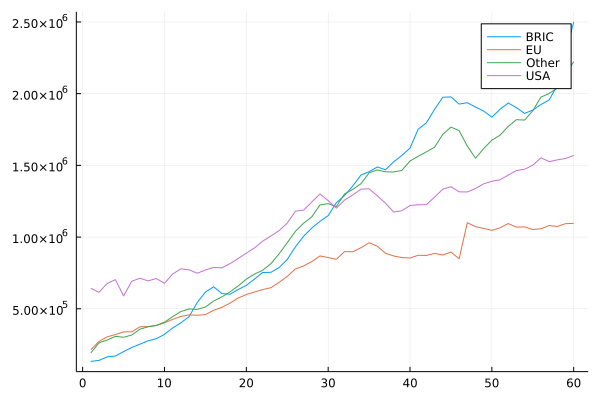

In [48]:
using StatsPlots;
x = df[!,:t]; y = df[!,:eᵢₜ]
@df df plot(:t, :eᵢₜ, group = :i)

In [50]:
using Forecast;
plot(ar(arsim( 1.,0.,0.,100),1,false))

UndefVarError: UndefVarError: arsim not defined

In [2]:
# Load packages
using Dates, DataFrames, LinearAlgebra, Optim, Plots, Measures, StableRNGs;
using FredData: Fred, get_data;
using MessyTimeSeries;

# Initialise FredData
open(joinpath(homedir(), ".freddatarc"), "w") do f
    write(f, "1589008b17492e138d3d34b9350d636a")
end
f = Fred();

# Download seasonal adjusted (SA) industrial production (IP)
dates = get_data(f, "INDPRO", observation_start="1984-01-01", units="lin").data[!, :date];
sa_ip = get_data(f, "INDPRO", observation_start="1984-01-01", units="lin").data[!, :value];

# Download not seasonally adjusted (NSA) industrial production (IP)
nsa_ip = get_data(f, "IPB50001N", observation_start="1984-01-01", units="lin").data[:, :value];

# Set random seed
rng = StableRNG(1);

API key loaded.



(process:9748): GLib-GIO-WARNING **: 13:17:20.240: Unexpectedly, UWP app `KDEe.V.Okular_22.401.1031.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs
